In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

--- Linear Regression ---
Fitted Linear Model: Y = 1.9905X + 0.0429
SSE: 0.1962
R-squared: 0.9988
Predictions for X=[2.5, 9.0]: Y_pred=[5.019047619047621, 17.957142857142856]


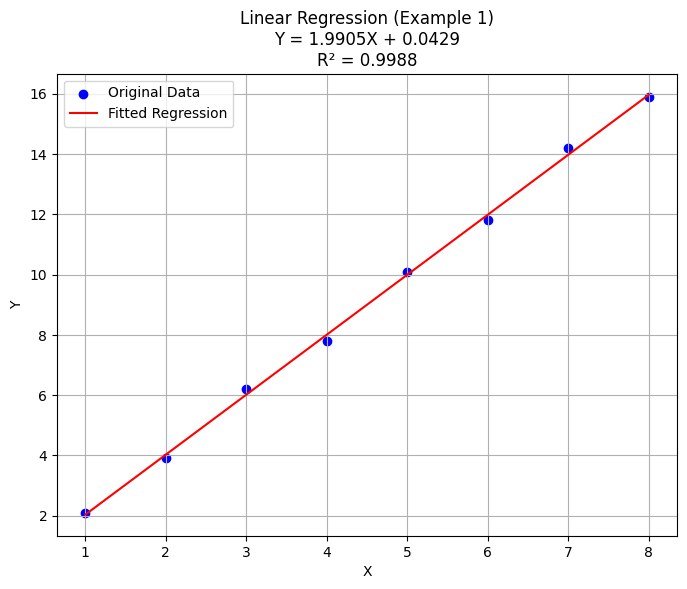



--- Power-Law Regression ---


AttributeError: module 'pandas' has no attribute 'np'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function to calculate sums, as per the formulas
def _calculate_sums(x_values, y_values):
    """
    Calculates the necessary sums for linear regression formulas.
    ΣX, ΣY, ΣXY, ΣX², n
    """
    if len(x_values) != len(y_values):
        raise ValueError("x_values and y_values must have the same number of elements.")
    if len(x_values) < 2:
        raise ValueError("At least two data points are required for regression.")

    n = len(x_values)
    sum_x = x_values.sum()
    sum_y = y_values.sum()
    sum_xy = (x_values * y_values).sum()
    sum_x_squared = (x_values ** 2).sum()

    return n, sum_x, sum_y, sum_xy, sum_x_squared

class RegressionFromScratch:
    """
    Implements regression models from scratch based on provided notes.
    """

    def __init__(self):
        self.m = None
        self.c = None
        self.a = None
        self.b = None
        self.model_type = None
        self.x_original = None
        self.y_original = None
        self.y_predicted = None
        self.sse = None # Sum of Squared Errors
        self.r_squared = None # Coefficient of determination

    def linear_regression(self, x_values, y_values):
        """
        Performs linear regression (y = mx + c) based on the formulas:
        m = (n ΣXᵢYᵢ - ΣXᵢ ΣYᵢ) / (n ΣXᵢ² - (ΣXᵢ)²)
        c = (ΣYᵢ - m ΣXᵢ) / n
        """
        self.model_type = "linear"
        self.x_original = pd.Series(x_values)
        self.y_original = pd.Series(y_values)

        n, sum_x, sum_y, sum_xy, sum_x_squared = _calculate_sums(self.x_original, self.y_original)

        # Calculate m (slope)
        numerator_m = (n * sum_xy) - (sum_x * sum_y)
        denominator_m = (n * sum_x_squared) - (sum_x**2)

        if denominator_m == 0:
            # This happens if all x_values are the same, or n is too small.
            # The line is vertical (undefined slope) or ill-defined.
            raise ValueError(
                "Denominator for m is zero. Cannot compute slope. "
                "This might happen if all x-values are identical."
            )
        self.m = numerator_m / denominator_m

        # Calculate c (y-intercept)
        self.c = (sum_y - self.m * sum_x) / n
        
        self._calculate_fit_metrics()
        return self.m, self.c

    def power_law_regression(self, x_values, y_values):
        """
        Performs power-law regression (y = ax^b) by linearizing the equation:
        log₁₀(y) = log₁₀(a) + b * log₁₀(x)
        Let Y' = log₁₀(y), X' = log₁₀(x), c' = log₁₀(a), m' = b
        Then Y' = c' + m'X'
        """
        self.model_type = "power_law"
        self.x_original = pd.Series(x_values)
        self.y_original = pd.Series(y_values)

        if (self.x_original <= 0).any() or (self.y_original <= 0).any():
            raise ValueError("For power-law regression (y=ax^b), all x and y values must be positive for log transformation.")

        # Transform data using base-10 logarithm, as implied by notes' example
        x_prime = self.x_original.apply(lambda x: pd.Series(x).map(lambda v: pd.np.log10(v))[0])
        y_prime = self.y_original.apply(lambda y: pd.Series(y).map(lambda v: pd.np.log10(v))[0])

        n, sum_x_prime, sum_y_prime, sum_xy_prime, sum_x_squared_prime = _calculate_sums(x_prime, y_prime)

        # Calculate m' (which is b)
        numerator_m_prime = (n * sum_xy_prime) - (sum_x_prime * sum_y_prime)
        denominator_m_prime = (n * sum_x_squared_prime) - (sum_x_prime**2)

        if denominator_m_prime == 0:
            raise ValueError(
                "Denominator for m' (b) is zero. Cannot compute exponent. "
                "This might happen if all log(x)-values are identical."
            )
        self.b = numerator_m_prime / denominator_m_prime # This is m'

        # Calculate c' (which is log₁₀(a))
        log10_a = (sum_y_prime - self.b * sum_x_prime) / n # This is c'

        # Recover a
        self.a = 10**log10_a
        
        self._calculate_fit_metrics()
        return self.a, self.b

    def predict(self, x_test_values):
        """
        Predicts y values for given x_test_values using the fitted model.
        """
        x_test = pd.Series(x_test_values)
        if self.model_type == "linear":
            if self.m is None or self.c is None:
                raise RuntimeError("Linear model not fitted yet. Call linear_regression first.")
            return self.m * x_test + self.c
        elif self.model_type == "power_law":
            if self.a is None or self.b is None:
                raise RuntimeError("Power-law model not fitted yet. Call power_law_regression first.")
            if (x_test <= 0).any() and self.b < 0 : # Or if b is not an integer for negative x
                 print("Warning: Predicting for non-positive x in power law. Ensure this is meaningful.")
            # Handle non-positive x values carefully if b is not an integer, to avoid complex numbers
            # For simplicity here, we assume x_test is positive for power law or b allows non-positive x.
            return self.a * (x_test**self.b)
        else:
            raise RuntimeError("Model not fitted yet or unknown model type.")

    def _calculate_fit_metrics(self):
        """
        Calculates SSE and R-squared for the fitted model on original data.
        The notes mention E = Σ(Y - Ŷ)² which is SSE.
        R² = 1 - (SSE / SST) where SST = Σ(Y - Y_mean)²
        """
        if self.x_original is None or self.y_original is None:
            return

        self.y_predicted = self.predict(self.x_original)
        
        # Sum of Squared Errors (SSE)
        self.sse = ((self.y_original - self.y_predicted)**2).sum()
        
        # Total Sum of Squares (SST)
        y_mean = self.y_original.mean()
        sst = ((self.y_original - y_mean)**2).sum()
        
        if sst == 0: # Happens if all y_original values are the same
            self.r_squared = 1.0 if self.sse == 0 else 0.0 # Or undefined, treat as 0 if error
        else:
            self.r_squared = 1 - (self.sse / sst)

    def plot_regression(self, title_suffix=""):
        """
        Plots the original data and the fitted regression line/curve.
        """
        if self.x_original is None or self.y_original is None or self.y_predicted is None:
            print("No data or model to plot. Fit a model first.")
            return

        plt.figure(figsize=(8, 6))
        plt.scatter(self.x_original, self.y_original, color='blue', label='Original Data')
        
        # For a smoother curve, especially for power law
        x_min = self.x_original.min()
        x_max = self.x_original.max()
        x_plot = pd.Series([x_min + (x_max - x_min) * i / 199 for i in range(200)])
        y_plot = self.predict(x_plot)
        
        plt.plot(x_plot, y_plot, color='red', label='Fitted Regression')
        
        equation = ""
        if self.model_type == "linear":
            equation = f'Y = {self.m:.4f}X + {self.c:.4f}'
        elif self.model_type == "power_law":
            equation = f'Y = {self.a:.4f}X^{{{self.b:.4f}}}'
            
        plt.title(f'{self.model_type.capitalize()} Regression {title_suffix}\n{equation}\nR² = {self.r_squared:.4f}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
        plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # 1. Linear Regression Example
    print("--- Linear Regression ---")
    # Sample data similar to what might be used for linear regression
    x_linear = pd.Series([1, 2, 3, 4, 5, 6, 7, 8])
    y_linear = pd.Series([2.1, 3.9, 6.2, 7.8, 10.1, 11.8, 14.2, 15.9]) # Roughly y = 2x + 0

    linear_model = RegressionFromScratch()
    try:
        m, c = linear_model.linear_regression(x_linear, y_linear)
        print(f"Fitted Linear Model: Y = {m:.4f}X + {c:.4f}")
        print(f"SSE: {linear_model.sse:.4f}")
        print(f"R-squared: {linear_model.r_squared:.4f}")
        
        # Predictions
        x_test_linear = pd.Series([2.5, 9])
        y_pred_linear = linear_model.predict(x_test_linear)
        print(f"Predictions for X={x_test_linear.tolist()}: Y_pred={y_pred_linear.tolist()}")
        
        linear_model.plot_regression(title_suffix="(Example 1)")
    except ValueError as e:
        print(f"Error in linear regression: {e}")
    print("\n")

    # 2. Power-Law Regression Example
    # Using data from notes (File 1, Page 11) to verify:
    # X = [1, 2, 3] (approx from P = log10(X) values 0, 0.3, 0.48)
    # Y = [1, 4, 9] (from Ŷ = log10(Y) values 0, 0.6, 0.95)
    # Expected: Y = 1 * X^2 (so a=1, b=2)
    print("--- Power-Law Regression ---")
    x_power = pd.Series([1.0, 1.995, 3.0]) # Back-calculating from log10(X) ~ [0, 0.3, 0.477]
    y_power = pd.Series([1.0, 3.981, 8.913]) # Back-calculating from log10(Y) ~ [0, 0.6, 0.95]
    # A simpler case:
    # x_power = pd.Series([1.0, 2.0, 3.0, 4.0])
    # y_power = pd.Series([1.0, 8.0, 27.0, 64.0]) # y = 1 * x^3

    power_model = RegressionFromScratch()
    try:
        a, b = power_model.power_law_regression(x_power, y_power)
        print(f"Fitted Power-Law Model: Y = {a:.4f}X^{{{b:.4f}}}")
        print(f"Derived parameters: log₁₀(a) = {pd.np.log10(a):.4f}, b = {b:.4f}")
        print(f"SSE: {power_model.sse:.4f}")
        print(f"R-squared: {power_model.r_squared:.4f}")

        # Predictions
        x_test_power = pd.Series([1.5, 2.5])
        y_pred_power = power_model.predict(x_test_power)
        print(f"Predictions for X={x_test_power.tolist()}: Y_pred={y_pred_power.tolist()}")
        
        power_model.plot_regression(title_suffix="(Example from Notes, Y ≈ X²)")

    except ValueError as e:
        print(f"Error in power-law regression: {e}")

    # Another power law example (y = 2x^1.5)
    print("\n--- Power-Law Regression (Example 2) ---")
    x_power2 = pd.Series([1, 2, 3, 4, 5])
    a_true, b_true = 2, 1.5
    y_values = a_true * x_power2**b_true
    noise = pd.Series([pd.np.random.normal(0, 0.5) for _ in range(len(x_power2))])
    y_power2 = y_values + noise
    y_power2[y_power2 <= 0] = 0.1 # Ensure positivity for log

    power_model2 = RegressionFromScratch()
    try:
        a2, b2 = power_model2.power_law_regression(x_power2, y_power2)
        print(f"Fitted Power-Law Model: Y = {a2:.4f}X^{{{b2:.4f}}}")
        print(f"(True values were a={a_true}, b={b_true})")
        print(f"SSE: {power_model2.sse:.4f}")
        print(f"R-squared: {power_model2.r_squared:.4f}")
        power_model2.plot_regression(title_suffix="(Example 2, Y ≈ 2X^1.5)")
    except ValueError as e:
        print(f"Error in power-law regression: {e}")

    # Test case for denominator_m == 0 in linear regression
    print("\n--- Linear Regression (Identical X values test) ---")
    x_bad = pd.Series([2, 2, 2, 2])
    y_bad = pd.Series([1, 2, 3, 4])
    linear_model_bad = RegressionFromScratch()
    try:
        m_bad, c_bad = linear_model_bad.linear_regression(x_bad, y_bad)
    except ValueError as e:
        print(f"Caught expected error: {e}")

    # Test case for non-positive values in power law
    print("\n--- Power-Law Regression (Non-positive Y test) ---")
    x_power_bad = pd.Series([1, 2, 3])
    y_power_bad = pd.Series([1, 0, 9]) # Contains a zero
    power_model_bad = RegressionFromScratch()
    try:
        a_bad, b_bad = power_model_bad.power_law_regression(x_power_bad, y_power_bad)
    except ValueError as e:
        print(f"Caught expected error: {e}")
